## Домашняя работа 4. 

Максимальный балл за задание - 10.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

import warnings

## Данные


В этой домашней работе мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры, сравнивать и смешивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики AUC-ROC.

## Подбор гиперпараметров модели

В задачах машинного обучения следует различать параметры модели и гиперпараметры (структурные параметры). Обычно параметры модели настраиваются в ходе обучения (например, веса в линейной модели или структура решающего дерева), в то время как гиперпараметры задаются заранее (например, регуляризация в линейной модели или максимальная глубина решающего дерева). Каждая модель обычно имеет множество гиперпараметров, и нет универсальных наборов гиперпараметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор.

Для оптимизации гиперпараметров модели часто используют _перебор по сетке (grid search)_: для каждого гиперпараметра выбирается несколько значений, перебираются все комбинации значений и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется). Однако в этом случае нужно грамотно оценивать построенную модель, а именно делать разбиение на обучающую и тестовую выборку. Есть несколько схем, как это можно реализовать: 

 - Разбить имеющуюся выборку на обучающую и тестовую. В этом случае сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит _переобучение_ на тестовую выборку.
 - Для устранения описанной выше проблемы, можно разбить данные на 3 непересекающихся подвыборки: обучение (`train`), валидация (`validation`) и контроль (`test`). Валидационную подвыборку используют для сравнения моделей, а `test` — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.
 - Другой способ сравнения моделей — [кросс-валидация](http://en.wikipedia.org/wiki/Cross-validation_(statistics). Существуют различные схемы кросс-валидации:
  - Leave-One-Out
  - K-Fold
  - Многократное случайное разбиение выборки
  
Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинации. С учетом конечности времени на выполнение задания, возникает ряд компромиссов: 
  - сетку можно делать более разреженной, перебирая меньше значений каждого параметра; однако, надо не забывать, что в таком случае можно пропустить хорошую комбинацию параметров;
  - кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
  - параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации; такая стратегия не всегда приводит к оптимальному набору;
  - перебирать не все комбинации параметров, а небольшое число случайно выбранных.

## Задание

Загрузите набор данных *data.adult.csv*. Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [2]:
df = pd.read_csv('data.adult.csv')
df.sample(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
15119,43,Self-emp-inc,48087,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,<=50K
9049,34,Self-emp-not-inc,353881,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,60,<=50K
12536,43,Self-emp-inc,196945,HS-grad,9,Married-civ-spouse,Other-service,Husband,Asian-Pac-Islander,Male,0,0,78,<=50K
5210,49,Private,91251,HS-grad,9,Married-civ-spouse,Other-service,Husband,Asian-Pac-Islander,Male,0,0,40,<=50K
15977,26,Self-emp-not-inc,34307,Assoc-voc,11,Never-married,Farming-fishing,Own-child,White,Male,0,0,65,<=50K


In [3]:
df.shape

(16280, 14)

Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение numpy.nan. Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html). 

В данном датасете пропущенные значения обозначены как "?". 

**(0.5 балла)** Найдите все признаки, имеющие пропущенные значения. Удалите из выборки все объекты с пропусками.

In [4]:
df.isin(['?']).sum(axis=0)

age                 0
workclass         929
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        933
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
>50K,<=50K          0
dtype: int64

In [5]:
%time
df.replace("?", np.nan, inplace=True) 
df.dropna(inplace=True) 

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.78 µs


In [6]:
df.shape

(15347, 14)

In [7]:
# Работает медленнее
# %time
# df = df[(df != '?').all(axis=1)] 

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 

 - Выделите целевую переменную в отдельную переменную, удалите ее из датасета и преобразуйте к бинарному формату.
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [8]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', '>50K,<=50K'],
      dtype='object')

In [9]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
>50K,<=50K        object
dtype: object

In [10]:
num_cols = df.columns[df.dtypes == 'int64'].tolist() # колонки только числовых данных
print('Числовые признаки: ', *list(enumerate(num_cols)), sep='\n')

Числовые признаки: 
(0, 'age')
(1, 'fnlwgt')
(2, 'education-num')
(3, 'capital-gain')
(4, 'capital-loss')
(5, 'hours-per-week')


In [11]:
X = df[num_cols]
X.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40


In [12]:
y = df['>50K,<=50K'].map({'<=50K': 0, '>50K': 1})
y.head()

0    0
1    0
2    0
3    0
4    1
Name: >50K,<=50K, dtype: int64

## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 5 алгоритмов:
 - kNN
 - SGD Linear Classifier
 - Naive Bayes Classifier
 - Logistic Regression
 - SVC (Support Vector Classifier)
 
Для начала у первых двух алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - SGD Linear Classifier — оптимизируемая функция (*loss*)
 
Остальные параметры оставляйте в значениях по умолчанию. Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе GridSearchCV. В качестве схемы кросс-валидации используйте 5-fold cv.

**(1.5 балла)** Для каждого из первых двух алгоритмов подберите оптимальные значения указанных гиперпараметров. Постройте график среднего качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразите доверительный интервал (доверительный интервал задается границами [mean - std, mean + std]).

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [17]:
def draw_results(params, gridsearch, hyperparams):
    x_axis = hyperparams
    y_axis = gridsearch.cv_results_['mean_test_score']
    ci = gridsearch.cv_results_['std_test_score']

    fig, ax = plt.subplots()
    ax.plot(x_axis, y_axis)
    ax.fill_between(x_axis, (y_axis - ci), (y_axis + ci), color='b', alpha=.1)
    
    plt.xticks(rotation=45, ha="right")

    plt.xlabel(f'Value of hyperparams')
    plt.ylabel('ROC_AUC Cross-Val');
    
    
def GridSearch(model, params, hyperparams):
    
    gs = GridSearchCV(model, param_grid=params, cv=5, scoring='roc_auc')
    gs.fit(X, y)

    print(gs.best_params_)
    print(gs.best_score_)
    
    draw_results(params, gs, hyperparams)



{'n_neighbors': 4}
0.6407153603874729


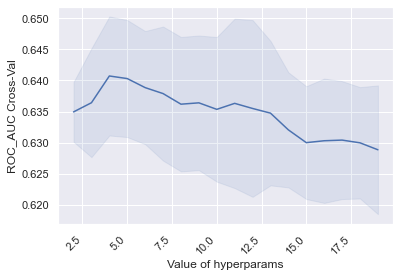

In [18]:
knn = KNeighborsClassifier()
n_neigh = np.arange(2, 20)
parameters = {'n_neighbors': n_neigh}

GridSearch(knn, parameters, n_neigh)

Пришлось увеличить макс. количество итераций для SGD-классификатора.

/Users/mari/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(
/Users/mari/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(
/Users/mari/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(
/Users/mari/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.

{'loss': 'squared_hinge'}
0.6205767476597883


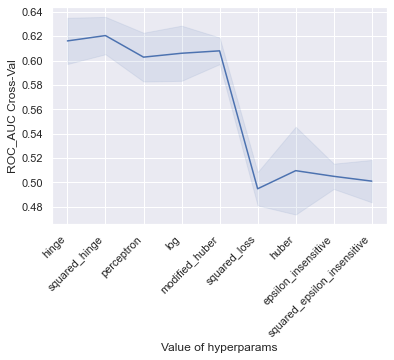

In [21]:
sgd = SGDClassifier(max_iter=10000)
loss = ['hinge', 'squared_hinge', 'perceptron', 'log', 'modified_huber',
                   'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
parameters = {'loss': loss}

GridSearch(sgd, parameters, loss)

Что вы можете сказать о получившихся графиках?

In [ ]:
# Нормировка сильно меняет положение дел и заметно улучшает кач-во моделей.
# И оптимальные значения настраиваемых гиперпараметров меняются.
# В целом, графики добавляют наглядности, но это очевидно:)

# Главный вывод, пожалуй - что гиперпараметры могут сильно повлиять на кач-во модели, с ними нужно работать.

**(0.75 балла)** Также подберём параметр регуляризации C в алгоритмах LogisticRegression и SVC.

{'C': 0.01}
0.5741274088512222


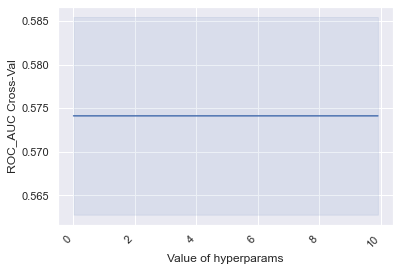

In [22]:
# Гиперпараметры с лог. регрессией не изменили кач-во

clf = LogisticRegression()
logr_c = np.arange(0.01, 10, 0.1)
parameters = {'C': logr_c}

GridSearch(clf, parameters, logr_c)

{'C': 0.1}
0.639827192131192


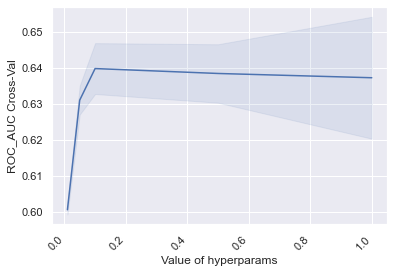

In [23]:
svm = SVC()
svm_c = [0.01, 0.05, 0.1, 0.5, 1]
parameters = {'C': svm_c}

GridSearch(svm, parameters, svm_c)

**(0.75 балла)** Изучите документацию по алгоритму [Naive Bayes Classifier](https://scikit-learn.org/stable/modules/naive_bayes.html) и подберите возможные гиперпараметры для этого алгоритма.

{'var_smoothing': 7.924828983539185e-11}
0.8250362279025645


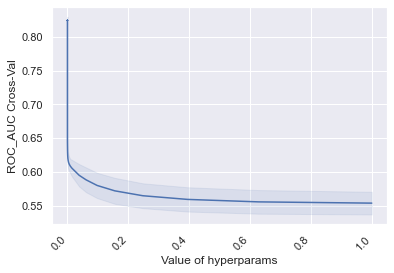

In [24]:
# У Наивного Байесовского классификатора в качестве гиперпараметров выступают var_smoothing - сглаживание, чтобы избавиться от нулей в вероятностях
# Сглаживание Лапласа (add-one smoothing) - прибавление 1 ко всем вероятностям.
# Но 1 дает очень большую погрешность, поэтому лучше прибавлять маленькую константу (add-k smoothing)
# Именно такую константу мы и подбираем в var_smoothing.

# Есть еще некие prior, которые дают веса признакам, но мне не совсем понятно, какие значения они могут принимать.
bayes = GaussianNB()
nb_c = np.logspace(0, -20, num=100)
parameters = {'var_smoothing': nb_c}

GridSearch(bayes, parameters, nb_c)

При обучении алгоритмов стоит обращать внимание не только на качество, но и каким образом они работают с данными. В этой задаче получилось так, что некоторые из используемых алгоритмов чувствительны к масштабу признаков. Чтобы убедиться, что это как-то могло повлиять на качество давайте посмотрим на сами признаки.

**(0.5 балла)** Постройте гистограммы для признаков *age*, *fnlwgt*, *capital-gain*. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масшитабирование повлиять на работу этих алгоритмов?

In [25]:
X.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40


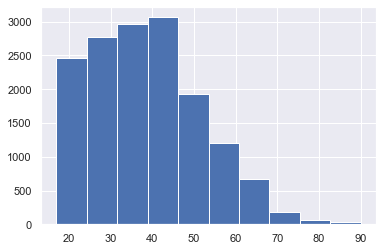

In [27]:
df['age'].hist();

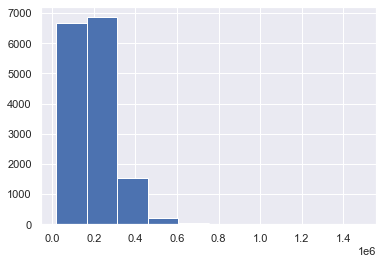

In [29]:
df['fnlwgt'].hist();

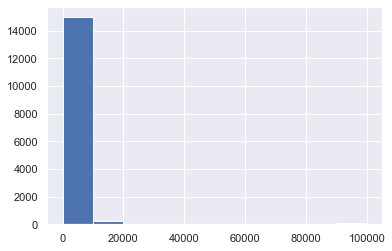

In [30]:
df['capital-gain'].hist();

In [31]:
# Видим, что область значений у age [10; 90] - довольно небольшая
# Зато у fnlwgt и capital-gain очень большая (особенно у fnlwgt) - отличие от age на несколько порядков!
# Это плохо для многих алгоримнов классификации: knn - искажается пространство, могут быть найдены неверные соседи
# SGD классификатора, логистической регрессии и SVM - 
# Масштабирование признаков должно улучшить качество (возможно в неоторых случаях, значительно)

Масштабирование признаков можно выполнить, например, одним из следующих способов способами:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

Похожие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).
 
**(1 балл)** Масштабируйте все вещественные признаки одним из указанных способов и подберите оптимальные значения гиперпараметров аналогично пункту выше.

In [34]:
def draw_results(params, gridsearch, hyperparams):
    x_axis = hyperparams
    y_axis = gridsearch.cv_results_['mean_test_score']
    ci = gridsearch.cv_results_['std_test_score']

    fig, ax = plt.subplots()
    ax.plot(x_axis, y_axis)
    ax.fill_between(x_axis, (y_axis - ci), (y_axis + ci), color='b', alpha=.1)
    
    plt.xticks(rotation=45, ha="right")

    plt.xlabel(f'Value of hyperparams')
    plt.ylabel('ROC_AUC Cross-Val');
    
    
def GridSearch(model, params, hyperparams):
    
    gs = GridSearchCV(model, param_grid=params, cv=5, scoring='roc_auc')
    
    pipe = Pipeline([
    ('scaler_', StandardScaler()),
    ('model_', gs)
    ])

    pipe.fit(X, y)

    print(gs.best_params_)
    print(gs.best_score_)
    
    draw_results(params, gs, hyperparams)

{'n_neighbors': 19}
0.8263922336504367


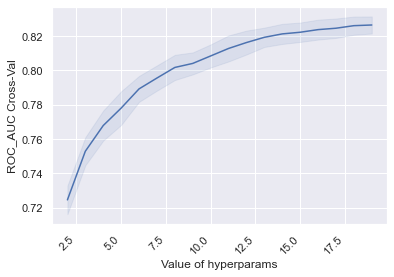

In [35]:
# У kNN заметно выросло качество (почти на 20%)
# и с масштабированными признаками чем больше соседей мы учитываем, тем лучше

knn = KNeighborsClassifier()
n_neigh = np.arange(2, 20)
parameters = {'n_neighbors': n_neigh}

GridSearch(knn, parameters, n_neigh)

{'loss': 'log'}
0.82237009313885


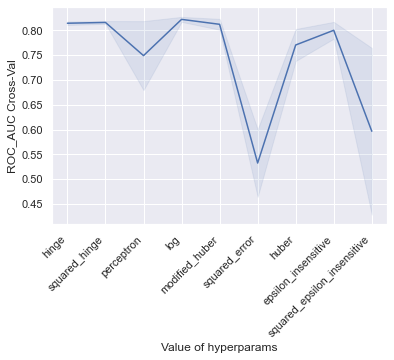

In [37]:
# На 20% выросло кач-во и у SGD классификатора

sgd = SGDClassifier(max_iter=10000)
loss = ['hinge', 'squared_hinge', 'perceptron', 'log', 'modified_huber',
                   'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
parameters = {'loss': loss}

GridSearch(sgd, parameters, loss)

{'C': 0.11}
0.8251316622518701


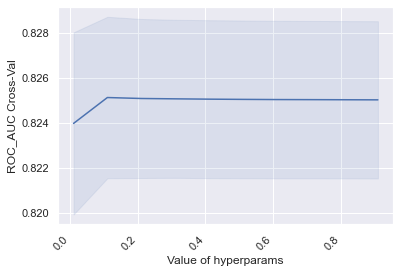

In [38]:
# Качество выросло >20% на логистической регрессии

clf = LogisticRegression()
logr_c = np.arange(0.01, 1, 0.1)
parameters = {'C': logr_c}

GridSearch(clf, parameters, logr_c)

{'C': 0.005}
0.8147064330085897


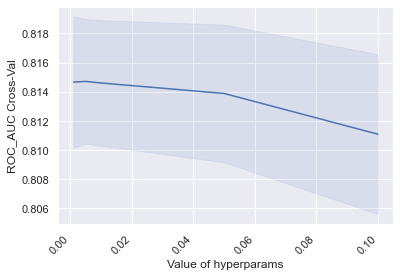

In [41]:
# Качестов SVM улучшилось, гиперпараметр изменился

svm = SVC()
svm_c = [0.001, 0.005, 0.01, 0.05, 0.1]
parameters = {'C': svm_c}

GridSearch(svm, parameters, svm_c)

{'var_smoothing': 0.1555676143930472}
0.8307645881098576


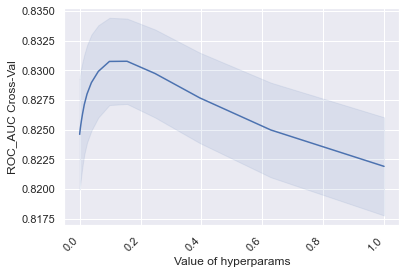

In [42]:
# Интересно, что благодаря масштабированию признаков, наш гиперпараметр для сглаживания стал больше

bayes = GaussianNB()
nb_c = np.logspace(0, -20, num=100)
parameters = {'var_smoothing': nb_c}

GridSearch(bayes, parameters, nb_c)

Изменилось ли качество у некоторых алгоритмов?

**(1,5 балла)** Теперь сделайте перебор нескольких гиперпараметров по сетке и найдите оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае, например:
 - KNN — число соседей (*n_neighbors*) и метрика (*metric*)
 - SGDClassifier — оптимизируемая функция (*loss*) и *penalty*

Для оставшихся трех алгоритмов самостоятельно определите, какие наборы гиперпараметров необходимо перебирать и осуществите перебор.

Обратите внимание, что эта операция может быть ресурсо- и трудоемкой.

In [43]:
def GridSearch(model, params):
    
    gs = GridSearchCV(model, param_grid=params, cv=5, scoring='roc_auc')
    
    pipe = Pipeline([
    ('scaler_', StandardScaler()),
    ('model_', gs)
    ])

    pipe.fit(X, y)

    print(gs.best_params_)
    print(gs.best_score_)

KNN

In [50]:
%%time
warnings.simplefilter("ignore")


knn = KNeighborsClassifier()
n_neigh = np.arange(2, 20)
distance = ('euclidean', 'manhattan', 'chebyshev', 'minkowski',
            'wminkowski', 'seuclidean', 'mahalanobis')
parameters = {'n_neighbors': n_neigh,
             'metric': distance}

GridSearch(knn, parameters)

{'metric': 'manhattan', 'n_neighbors': 19}
0.8285211334362064
CPU times: user 34.2 s, sys: 218 ms, total: 34.4 s
Wall time: 34.7 s


SGDClassifier

In [46]:
%%time
sgd = SGDClassifier(max_iter=10000)
loss = ['hinge', 'squared_hinge', 'perceptron', 'log', 'modified_huber',
                   'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
parameters = {'loss': loss,
             'penalty': ['l1', 'l2', 'elasticnet']}

GridSearch(sgd, parameters)

{'loss': 'log', 'penalty': 'elasticnet'}
0.823661772723072
CPU times: user 18.2 s, sys: 78.2 ms, total: 18.3 s
Wall time: 4.62 s


Логистическая регрессия

In [48]:
%%time
warnings.simplefilter("ignore")


clf = LogisticRegression()
logr_c = np.arange(0.01, 1, 0.1)
parameters = {'C': logr_c,
             'penalty': ['none', 'l1', 'l2', 'elasticnet']}

GridSearch(clf, parameters)

{'C': 0.11, 'penalty': 'l2'}
0.8251316622518701
CPU times: user 5.48 s, sys: 81.2 ms, total: 5.56 s
Wall time: 1.41 s


SVM

In [49]:
%%time

svm = SVC()
svm_c = [0.001, 0.005, 0.01, 0.05, 0.1]
parameters = {'C': svm_c,
             'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
             'gamma': ['scale', 'auto'],
             'degree': np.arange(1, 5)
             }

GridSearch(svm, parameters)


{'C': 0.001, 'degree': 1, 'gamma': 'scale', 'kernel': 'poly'}
0.8164369441820615
CPU times: user 48min 49s, sys: 1min 27s, total: 50min 16s
Wall time: 50min 31s


In [51]:
# Наивный Байес с гиперпараметром var_smoothing уже сделан выше, с графиком.
# Здесь запустим такой же код, но засечем время работы алгоритма

In [52]:
%%time

bayes = GaussianNB()
nb_c = np.logspace(0, -20, num=100)
parameters = {'var_smoothing': nb_c}

GridSearch(bayes, parameters)

{'var_smoothing': 0.1555676143930472}
0.8307645881098576
CPU times: user 2.33 s, sys: 18.3 ms, total: 2.35 s
Wall time: 2.35 s


Какой из алгоритмов имеет наилучшее качество? 

In [53]:
# Судя по всему, Наивный Байес с качеством на roc_auc 0.83.
# Но если в knn передать больше соседей (я пробовала до 30), то можно повысить качество до 0.836 и больше.
# Не знаю, хорошо ли позволять knn учитывать так много соседей.

**(0.5 балла)** Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

In [54]:
# SGD, логистическая регрессия и байес с перебором параметров работают за секунды,
# KNN чуть дольше, почти 2 минуты на MacBook Air 2015, MacBook Pro 2020 - за полминуты
# SVM работает очень долго (50 минут): у него много параметров
# + время работы алгоритма сильно зависит от кол-ва объектов.
# Судя по докуметации, увеличение скорости колеблется от квадратичного до кубического (!)

## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков. 

**(0.5 балла)** Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) из sklearn).

In [55]:
df = pd.get_dummies(df, columns=['workclass', 'education', 'marital-status', 'occupation',
                                 'relationship', 'race', 'sex'], drop_first=True)

df.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,">50K,<=50K",workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,34,284843,9,594,0,60,<=50K,1,0,0,...,1,0,0,0,0,0,1,0,0,1
1,40,190290,10,0,0,40,<=50K,0,1,0,...,1,0,0,0,0,0,0,0,1,1
2,36,177858,13,0,0,40,<=50K,1,0,0,...,0,0,1,0,0,0,0,0,1,1
3,22,184756,10,0,0,30,<=50K,0,1,0,...,0,0,1,0,0,0,0,0,1,0
4,47,149700,13,15024,0,40,>50K,0,1,0,...,0,0,0,0,0,0,0,0,1,1


In [56]:
X = df.drop('>50K,<=50K', axis=1)
X.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,34,284843,9,594,0,60,1,0,0,0,...,1,0,0,0,0,0,1,0,0,1
1,40,190290,10,0,0,40,0,1,0,0,...,1,0,0,0,0,0,0,0,1,1
2,36,177858,13,0,0,40,1,0,0,0,...,0,0,1,0,0,0,0,0,1,1
3,22,184756,10,0,0,30,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,47,149700,13,15024,0,40,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1


Так как после кодирования признаков получилось достаточно много, в этой работе мы не будем добавлять их и подбирать заново оптимальные гиперпараметры. 

**(0.5 балла)** Добавьте к масштабированным вещественным признакам закодированные категориальные и обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 5-Fold CV. Для этого удобно воспользоваться функцией [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [57]:
from sklearn.model_selection import cross_val_score


def pipe_cv(model):
    
    pipe = Pipeline([
        ('scaler_', StandardScaler()),
        ('model_', model)
    ])

    return cross_val_score(pipe, X, y, cv=5, scoring='roc_auc').mean()

In [60]:
print('knn: ', pipe_cv(KNeighborsClassifier(metric='manhattan', n_neighbors=19)))
print('SGD: ', pipe_cv(SGDClassifier(loss='log', penalty='elasticnet')))
print('LgR: ', pipe_cv(LogisticRegression(C=0.11, penalty='l2')))
print('SVM: ', pipe_cv(SVC(C=0.001, degree=1, gamma='scale', kernel='poly'))) # SVM возьмем с параметром C. С большим кол-вом параметров не доработало...
print('NB:  ', pipe_cv(GaussianNB(var_smoothing=0.156)))


knn:  0.8742812847750159
SGD:  0.8957249785762142
LgR:  0.9035399451783024
SVM:  0.8844070771242072
NB:   0.8580087390749556


Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?

In [61]:
# Да! Лучшим классификатором с новыми признаками стала логистическая регрессия.
# Не сильно отстает SGD-классификатор